In [2]:
import sys
sys.path.append("../../Chapter_3/")

import pickle

import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import fastai
from fastai.basics import Learner, DataLoaders
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.torch_core import trainable_params

# from Utils.model_datasets import RPIDataset
from Utils.train import set_seed, MainModelDenseInputSizeCalculator, main_model_splitter
from Utils.model_utils import LossLogger
from Utils.model_datasets import EncodedRPIDataset
from Utils.model_blocks import *
from Utils.train import BlockInputShapeReformatter, MainModelDenseInputSizeCalculator

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import seaborn as sbn
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, matthews_corrcoef

In [4]:
fastai.__version__

'2.3.1'

In [42]:
# The number of Tat samples we have to refine model
with open("../Data/TrainingData/FullEmbeddedHIVTrainingData.pickle",'rb') as infile:
    TAT_TRAINDATA_COUNT = len(pickle.load(infile)[0])
    print(f"Number of interactions: {TAT_TRAINDATA_COUNT}")

Number of interactions: 142


In [3]:
NNI_DIR = "/data/Chapter_3/nni"
res_params = pd.read_csv(f"{NNI_DIR}/experiment_results/Main_StackedRes.csv", index_col = 0).dropna().sort_values('final_metric')

In [4]:
def determine_block_name_from_params(params):
    """
    Searches for a parameter exclusive to a different block type
    within the given parameters, and returns the corresponding
    block name. 
    """
    
    param_names = params.keys()
    if 'pooling_type' in param_names:
        return 'ConvPool'
    elif 'reccurent_type' in param_names:
        return 'Reccurent'
    elif 'layer_count' in param_names:
        return 'Attention'
    elif 'hidden_sizes' in param_names:
        return 'StackedRes'
    elif 'hidden_layer_sizes' in param_names:
        return 'Dense'
    elif 'sae_type' in param_names:
        return 'SAE'
    
class BlockInializer:
    """
    Used to initialize MainModel blocks from the parameters and 
    """
    
    def __init__(self, seed):
        self.seed = seed
    
    def _reformat_block_act(self, block_params):
        preprocessed_block_str = re.sub(r"'act': 'nn.(.+?)\(\)'", r"'act': nn.\1()", block_params)
        preprocessed_block_str = re.sub(r"'act_cls': 'nn.(.+?)\'", r"'act_cls': nn.\1", preprocessed_block_str)
        return preprocessed_block_str
    
    def _reformat_list_str(self, block_params):
        preprocessed_block_str = re.sub(r"'\[(.*)\]'", r"[\1]", block_params)
        return preprocessed_block_str
    
    def generate_block_str(self, block_name, input_size, block_params):
        return f"{block_name}Block({input_size}, **{block_params})"
    
    def _reformat_sae_block(self, input_size, preprocessed_block_str):
        return preprocessed_block_str.replace(f"{input_size}, ","")
    
    def initialize_block(self, block_name, input_size, block_params):
        block_str = self.generate_block_str(block_name, input_size, block_params)
        preprocessed_block_str = self._reformat_block_act(block_str)
        preprocessed_block_str = self._reformat_list_str(preprocessed_block_str)
        
        if block_name == 'SAE':
            preprocessed_block_str = self._reformat_sae_block(input_size, preprocessed_block_str)
        
        set_seed(self.seed)
        print(preprocessed_block_str)
        return eval(preprocessed_block_str)

def swap_seq_input_order(data : list) -> None:
    seq1, seq2 = data[0], data[1]
    data[0] = seq2
    data[1] = seq1

def initiate_lr_option(lr_option, lr_min, lr_steep):
    "having min first is intentional. It results in better performance"
    options = {'slice' : slice(lr_min, lr_steep), 'min' : lr_min}
    return options[lr_option]

In [5]:
SEED = 255

PARAMS = res_params.iloc[0,:].to_dict()

_ = PARAMS.pop("final_metric")
LR_OPTION = PARAMS.pop("lr_max_arg")
BATCHSIZE = PARAMS.pop("batchsize")
MAIN_ACT = eval(PARAMS.pop("act"))

main_model_params = {key : value for key,value in PARAMS.items() if 'rna' not in key and 'prot' not in key}
rna_block_params = {key.replace("rna_","") : value for key,value in PARAMS.items() if 'rna' in key}
prot_block_params = {key.replace("prot_","") : value for key,value in PARAMS.items() if 'prot' in key}

rna_block_name = determine_block_name_from_params(rna_block_params)
prot_block_name = determine_block_name_from_params(prot_block_params)

# TEMPORARY: ASSUMES THAT PROT AND RNA BLOCKS ARE IDENTICAL
block_name = prot_block_name
block_name

'StackedRes'

In [6]:
#####################################################
# Load params
######################################################

with open("../Data/TrainingData/FullEmbeddedTrainingData.pickle",'rb') as handle:
    data = pickle.load(handle)

In [7]:
y = data

In [8]:
# def perform_fold_evaluation()

def stratify_sample_n_entries_from_data_list(data_list : list, n : int) -> list:
    percent = n / len(data_list[0])
    
    if percent != 1:

        _, sample_idx = train_test_split(range(len(data_list[0])), random_state = 255, test_size = percent, 
                                             stratify = data_list[-1])

        stratified_sample =[X[sample_idx] for X in data_list]
        return stratified_sample
    else:
        return data_list

In [9]:
t = stratify_sample_n_entries_from_data_list(data, 1000)
print(f"""Positive sample count: {len(t[-1]) - t[-1].sum()}
Negative sample count: {len(t[-1]) - t[-1].sum()}""")

Positive sample count: 500.0
Negative sample count: 500.0


In [10]:
from sklearn.metrics import confusion_matrix

def specificity_score(y_true, y_pred):
    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    return specificity

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, recall_score
from tqdm.notebook import tqdm

import os

shape_reformatter = BlockInputShapeReformatter()
BLOCKNAME = "StackedRes"
PATIENCE = 10

SAMPLE_COUNTS = [100,200,5000,10000,15000,20000,len(data[0])]
METRICS = ['acc','f1','rocauc','avg_precision','sensitivity', 'specificity']

performance_dict = {n : {metric : list() for metric in METRICS} for n in SAMPLE_COUNTS}

if os.path.exists("5_fold_validation_performance.csv"):
    fold_eval_performance = pd.read_csv("5_fold_validation_performance.csv", index_col = 0)

else:

    for n in tqdm(SAMPLE_COUNTS):

        sampled_data = stratify_sample_n_entries_from_data_list(data, n)

        skf = StratifiedKFold(n_splits = 5, random_state = 255, shuffle = True)
        skf.get_n_splits(sampled_data[0], sampled_data[-1])

        for train_index, test_index in tqdm(skf.split(sampled_data[0], sampled_data[-1]), total = 5):   

            #####################################################
            # Generate train, test, val data
            #####################################################

            train_data, test_data = zip(*[(X[train_index], X[test_index]) for X in sampled_data])

            test_idx, val_idx = train_test_split(range(len(test_data[0])), random_state = 255, test_size = 0.5, 
                                                 stratify = test_data[-1])

            test_data, val_data = zip(*[(X[test_idx], X[val_idx]) for X in test_data])

    #         print(f"""Train data: {len(train_data[0])} | + samples: {sum(train_data[-1])} | - samples: {len(train_data[-1]) - sum(train_data[-1])}    
    #     Test data: {len(test_data[0])} | + samples: {sum(test_data[-1])} | - samples: {len(test_data[-1]) - sum(test_data[-1])}
    #     Val data: {len(val_data[0])} | + samples: {sum(val_data[-1])} | - samples: {len(val_data[-1]) - sum(val_data[-1])}
    #     ---""")

            #####################################################
            # Preprocess train, test, val data
            #####################################################

            refine_train_data = [shape_reformatter.reformat_input(BLOCKNAME, train_data[i].float()) for i in range(2)] + [train_data[-1].float()]
            swap_seq_input_order(refine_train_data)
            refine_train_dataset = EncodedRPIDataset(refine_train_data)

            refine_val_data = [shape_reformatter.reformat_input(BLOCKNAME, val_data[i].float()) for i in range(2)] + [val_data[-1].float()]
            swap_seq_input_order(refine_val_data)
            refine_val_dataset = EncodedRPIDataset(refine_val_data)

            refine_test_data = [shape_reformatter.reformat_input(BLOCKNAME, test_data[i].float()) for i in range(2)] + [test_data[-1].float()]
            proteins, rnas, y_true = refine_test_data
            y_true = y_true.reshape(-1,1)

            #####################################################
            # Generate model
            #####################################################

            block_initializer = BlockInializer(SEED)

            # Temporarily initializes blocks to calculate input size
            rna_block = block_initializer.initialize_block(rna_block_name, 1024, rna_block_params)
            prot_block = block_initializer.initialize_block(prot_block_name, 1024, prot_block_params)

            dense_input_calculator = MainModelDenseInputSizeCalculator(refine_train_data[0], refine_train_data[1])
            dense_input_size = dense_input_calculator.calcualte_input_shape(rna_blocks  = [rna_block.cpu()], 
                                                                            prot_blocks = [prot_block.cpu()])

            set_seed(255)
            rna_block = block_initializer.initialize_block(rna_block_name, 1024, rna_block_params)
            prot_block = block_initializer.initialize_block(prot_block_name, 1024, prot_block_params)

            main_model_params = eval(block_initializer._reformat_list_str(str(main_model_params)))

            set_seed(255)
            main_model = MainModel(rna_blocks  = [rna_block],
                                   prot_blocks = [prot_block],
                                   dense_input_size = dense_input_size,
                                   act = MAIN_ACT,
                                   **main_model_params).cuda()

            #####################################################
            # Train model
            #####################################################

            set_seed(255)
            loaders = DataLoaders.from_dsets(refine_train_dataset, refine_val_dataset,
                                             bs = BATCHSIZE,
                                             device = 0)

            learner = Learner(loaders, main_model,
                              splitter = main_model_splitter,
                              cbs = [EarlyStoppingCallback(patience = PATIENCE)],
                              loss_func = nn.BCELoss())

            lr_min, lr_steep = learner.lr_find()

            max_lr_arg = initiate_lr_option(LR_OPTION, lr_min, lr_steep)
            learner.fit_one_cycle(1000, lr_max = max_lr_arg)

            #####################################################
            # Evaluate performance on HIV-1 data
            #####################################################

            learner.model.eval()

            y_pred = learner.model(rnas.cuda(), proteins.cuda()).cpu().detach()
            y_pred_rounded = y_pred.round()

    #         print(f"ACCURACY: {round(accuracy_score(y_true, y_pred),3)}")
    #         print(f"F1 SCORE: {round(f1_score(y_true, y_pred),3)}")
    #         print(f"ROC AUC: {round(roc_auc_score(y_true, y_pred),3)}")
    #         print(f"AVERAGE PRECISION: {round(average_precision_score(y_true,y_pred),3)}")

            # METRICS = ['acc','f1','rocauc','avg_precision','sensitivity', 'specificity']

            performance_dict[n]['acc'].append(round(accuracy_score(y_true, y_pred_rounded),3))
            performance_dict[n]['f1'].append(round(f1_score(y_true, y_pred_rounded),3))
            performance_dict[n]['rocauc'].append(round(roc_auc_score(y_true, y_pred), 3))
            performance_dict[n]['avg_precision'].append(round(average_precision_score(y_true, y_pred),3))
            performance_dict[n]['sensitivity'].append(round(recall_score(y_true, y_pred_rounded),3))
            performance_dict[n]['specificity'].append(round(specificity_score(y_true, y_pred_rounded),3))

            print("---")

In [26]:
fold_eval_performance = fold_eval_performance.applymap(lambda x: eval(x))
fold_eval_performance.columns = fold_eval_performance.columns.astype(float)
fold_eval_performance

,100.0,200.0,5000.0,10000.0,15000.0,20000.0,24294.0
acc,"[0.8, 0.6, 0.8, 0.9, 0.5]","[0.85, 0.65, 0.75, 0.8, 0.95]","[0.952, 0.95, 0.948, 0.972, 0.96]","[0.974, 0.973, 0.965, 0.971, 0.981]","[0.969, 0.976, 0.974, 0.975, 0.985]","[0.976, 0.979, 0.982, 0.98, 0.974]","[0.986, 0.986, 0.98, 0.978, 0.981]"
f1,"[0.833, 0.667, 0.8, 0.909, 0.667]","[0.857, 0.741, 0.737, 0.818, 0.952]","[0.953, 0.951, 0.949, 0.973, 0.961]","[0.975, 0.974, 0.966, 0.972, 0.981]","[0.969, 0.976, 0.975, 0.976, 0.985]","[0.977, 0.979, 0.982, 0.98, 0.974]","[0.986, 0.986, 0.981, 0.978, 0.981]"
rocauc,"[0.92, 0.6, 0.84, 0.88, 0.76]","[0.93, 0.84, 0.85, 0.97, 1.0]","[0.985, 0.992, 0.983, 0.993, 0.989]","[0.992, 0.992, 0.992, 0.996, 0.997]","[0.991, 0.994, 0.996, 0.991, 0.995]","[0.993, 0.995, 0.995, 0.996, 0.994]","[0.996, 0.994, 0.995, 0.995, 0.994]"
avg_precision,"[0.927, 0.578, 0.853, 0.877, 0.821]","[0.953, 0.852, 0.899, 0.977, 1.0]","[0.982, 0.991, 0.981, 0.987, 0.988]","[0.99, 0.987, 0.975, 0.994, 0.995]","[0.988, 0.992, 0.986, 0.989, 0.993]","[0.988, 0.994, 0.994, 0.995, 0.99]","[0.995, 0.992, 0.993, 0.994, 0.989]"
sensitivity,"[1.0, 0.8, 0.8, 1.0, 1.0]","[0.9, 1.0, 0.7, 0.9, 1.0]","[0.984, 0.964, 0.976, 0.992, 0.996]","[0.998, 1.0, 0.994, 0.996, 0.996]","[0.995, 0.992, 1.0, 0.996, 0.993]","[0.989, 0.997, 0.997, 0.996, 0.995]","[0.995, 0.998, 0.999, 0.996, 0.996]"
specificity,"[0.6, 0.4, 0.8, 0.8, 0.0]","[0.8, 0.3, 0.8, 0.7, 0.9]","[0.92, 0.936, 0.92, 0.952, 0.924]","[0.95, 0.946, 0.936, 0.946, 0.966]","[0.943, 0.96, 0.948, 0.955, 0.977]","[0.964, 0.961, 0.966, 0.963, 0.952]","[0.976, 0.973, 0.961, 0.96, 0.965]"


In [13]:
def plot_frame(df,TAT_TRAINDATA_COUNT, axes):
    
    sbn.lineplot(data = df.iloc[:,:2].melt(), x = 'variable', y = 'value', marker = 'o', ax = axes[0])
    sbn.lineplot(data = df.iloc[:,2:].melt(), x = 'variable', y = 'value', marker = 'o', ax = axes[1])
    
    y_min, y_max = axes[0].get_ylim()
        
    axes[0].set_xlabel("RPI samples")
    axes[1].set_xlabel("RPI samples")
    
    axes[1].set_ylabel(None)

In [17]:
def fill_between_to_available_data(plt_data, avilable_data_count : int, ax, **kwargs):
    x = plt_data.lines[0].get_xdata().reshape(-1,1)
    y = plt_data.lines[0].get_ydata().reshape(-1,1)

    y_min, _ = ax.get_ylim()

    bottom = [y_min]*2

    linear = LinearRegression().fit(x,y)
    available_data_count_y = linear.predict(np.array([avilable_data_count]).reshape(-1,1))
    
    ax.fill_between([int(x[0][0]), avilable_data_count],[y[0][0], available_data_count_y[0][0]], [y_min]*2, **kwargs)

def remove_axis(ax, left = False, right = False, top = False, bottom = False):
    
    ax.tick_params(axis = 'y',    
                   which = 'both', 
                   left = not left, 
                   right = not right, 
                   labelleft = not left,
                   labelright = not right,
    )
    
    ax.tick_params(axis = 'x',         
                   which = 'both',  
                   top = not top,
                   bottom = not bottom,
                   labeltop = not top,
                   labelbottom = not bottom,
    )
    
    ax.spines['left'].set_visible(not left)
    ax.spines['right'].set_visible(not right)
    ax.spines['top'].set_visible(not top)
    ax.spines['bottom'].set_visible(not bottom)

In [18]:
def plot_sample_size_upscale_graph(df, metric, axes, lineplot_kwgs = dict(), fill_between_kwgs = dict()):
    assert axes.shape == (2,2), f"axes shape needs to be 2x2, gave shape: {axes.shape}"
    
    
    # marker = 'o', err_style="bars",
    smll_plt_data = sbn.lineplot(data = df.iloc[:,:2].melt(), x = 'variable', y = 'value', ax = axes[1,0], **lineplot_kwgs)

    sbn.lineplot(data = df.iloc[:,2:].melt(), x = 'variable', y = 'value', ax = axes[0,1], **lineplot_kwgs)

    small_data_plt = df.iloc[:,:2].melt()
    
    # alpha = 0.3
    fill_between_to_available_data(smll_plt_data, TAT_TRAINDATA_COUNT, axes[1,0], **fill_between_kwgs)

    axes[1,1].set_xlim(axes[0,1].get_xlim())
    axes[0,0].set_ylim(axes[0,1].get_ylim())

    axes[1,1].set_xlabel("RPI count")
    axes[1,0].set_xlabel("RPI count")

    axes[0,1].set_xlabel("")
    axes[0,1].set_ylabel("")

    axes[0,0].set_ylabel(metric)
    axes[1,0].set_ylabel(metric)

    remove_axis(axes[0,0], bottom = True, top = True, right = True)
    remove_axis(axes[0,1], top = True, left = True, right = True, bottom = True)
    remove_axis(axes[1,0], top = True, right = True)
    remove_axis(axes[1,1], left = True, top = True, right = True)

<ipython-input-33-bb2842e61461>:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


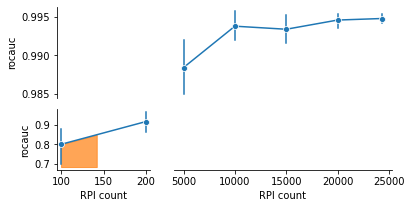

In [33]:
fig, axes = plt.subplots(2,2, figsize = (6,3), gridspec_kw = {'width_ratios': [0.3,0.7], 'height_ratios': [0.6,0.4], 'wspace' : 0.15, 'hspace' : 0.15})

metric = 'rocauc'
colors = sbn.color_palette("tab10", 2)

df = pd.DataFrame(dict(zip(fold_eval_performance.loc[metric,:].index, fold_eval_performance.loc[metric,:].values)))

plot_sample_size_upscale_graph(df, metric, axes, 
                               lineplot_kwgs = {'marker' : 'o', "err_style": "bars", 'color': colors[0]}, 
                               fill_between_kwgs = {'alpha' : 0.7, 'color' : colors[1]})

# Add axis break symbols on PP
# Combine and add 
# Make sigfigs consistant in PP
# Specify that shading is available HIV-1 RPIS for training in PP
plt.tight_layout()
plt.savefig("SampleCurve.png", dpi = 300)